<a href="https://colab.research.google.com/github/Khalil-Ravikson/test_detection_cars_ssd_mobilenet_v2/blob/main/test_detection1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


In [ ]:
# Importa o TensorFlow Hub
import tensorflow_hub as hub

# URL do modelo pré-treinado no TensorFlow Hub
model_url = "https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2"
model = hub.load(model_url)

In [ ]:
# Baixa uma nova imagem de teste de uma fonte confiável (Wikimedia)


# Carrega a imagem
image_path = "race_car.jpeg"
image_np = plt.imread(image_path)

# Adiciona uma nova dimensão para o "batch"
# O modelo espera uma imagem com 4 dimensões: [1, altura, largura, canais]
image_np_expanded = np.expand_dims(image_np, axis=0)

In [ ]:
# A função de inferência do modelo do TensorFlow Hub
detector = model.signatures['serving_default']

# Executa a detecção na imagem
# O modelo retorna um dicionário com os resultados
results = detector(tf.constant(image_np_expanded))

# Os resultados são tensores (TensorFlow Tensors), vamos convertê-los para NumPy arrays
result_boxes = results['detection_boxes'].numpy()
result_scores = results['detection_scores'].numpy()
result_classes = results['detection_classes'].numpy().astype(np.int64)

print("Detecção concluída! Agora vamos visualizar os resultados.")

Detecção concluída! Agora vamos visualizar os resultados.


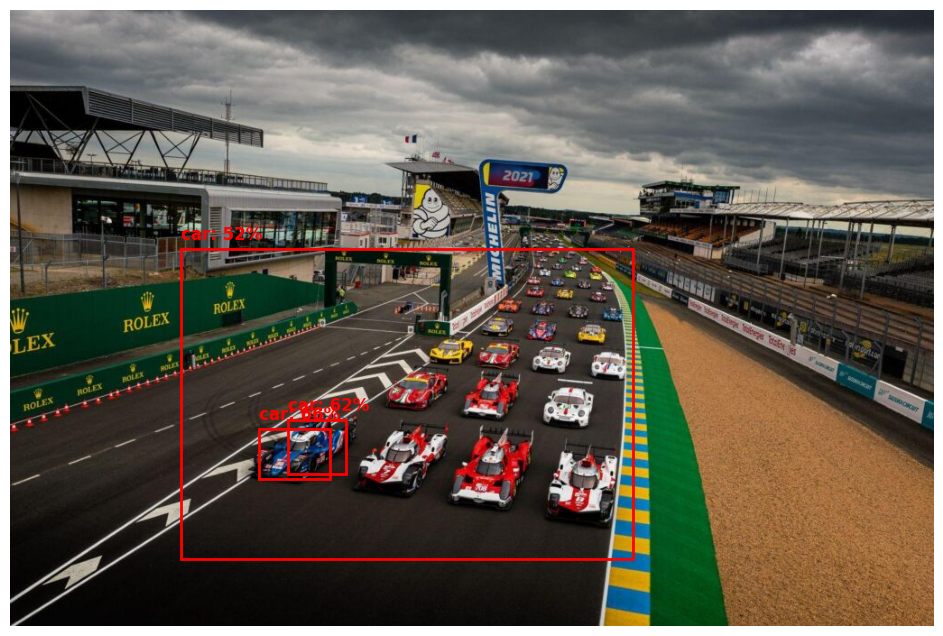

In [ ]:
# Define as classes de objetos que o modelo consegue identificar
# O modelo SSD MobileNet V2 é treinado no conjunto de dados COCO
# A classe 'carro' (car) geralmente tem o ID 3
# A classe 'pista de corrida' (track) não é um objeto específico nesse modelo
# Você pode consultar a lista completa de classes do COCO para ver o que ele pode detectar
COCO_CLASSES = {
    1: 'person', 2: 'bicycle', 3: 'car', 4: 'motorcycle', 5: 'airplane',
    6: 'bus', 7: 'train', 8: 'truck', 9: 'boat', 10: 'traffic light',
    # ... e muitas outras
}

# Configura a figura para plotar
plt.figure(figsize=(12, 8))
plt.imshow(image_np)
ax = plt.gca()

# Loop através dos resultados para desenhar as caixas
for i in range(result_boxes.shape[1]):
    score = result_scores[0, i]
    class_id = result_classes[0, i]

    # Desenha apenas se a confiança (score) for maior que 0.5 (50%)
    if score > 0.5:
        # Extrai as coordenadas da caixa delimitadora
        ymin, xmin, ymax, xmax = result_boxes[0, i]
        ymin *= image_np.shape[0]
        xmin *= image_np.shape[1]
        ymax *= image_np.shape[0]
        xmax *= image_np.shape[1]

        # Cria a caixa retangular
        box = plt.Rectangle(
            (xmin, ymin), xmax - xmin, ymax - ymin,
            fill=False, edgecolor='red', linewidth=2
        )

        # Adiciona o rótulo da classe e a confiança
        class_name = COCO_CLASSES.get(class_id, 'Unknown')
        label = f'{class_name}: {int(score*100)}%'
        plt.text(xmin, ymin - 10, label, color='red', fontsize=12, fontweight='bold')

        # Adiciona a caixa ao plot
        ax.add_patch(box)

plt.axis('off') # Oculta os eixos
plt.show()

In [ ]:
import cv2
print("OpenCV version:", cv2.__version__)

OpenCV version: 4.12.0


In [ ]:
# Mapeamento de classes (já definimos antes, mas é bom ter aqui)
COCO_CLASSES = {
    1: 'person', 2: 'bicycle', 3: 'car', 4: 'motorcycle', 5: 'airplane',
    6: 'bus', 7: 'train', 8: 'truck', 9: 'boat', 10: 'traffic light',
}

# Define o caminho para o vídeo de entrada e saída
video_path = 'myvideo.mp4'
output_path = 'video_com_deteccao.mp4'

# Abre o vídeo de entrada
cap = cv2.VideoCapture(video_path)

# Verifica se o vídeo foi aberto corretamente
if not cap.isOpened():
    print("Erro: Não foi possível abrir o arquivo de vídeo.")
else:
    # Pega as informações do vídeo
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)

    # Define o codificador e o objeto VideoWriter para salvar o novo vídeo
    fourcc = cv2.VideoWriter_fourcc(*'mp4v') # Codec para arquivos .mp4
    out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

    print("Processando vídeo...")

    while True:
        # Lê o próximo quadro
        ret, frame = cap.read()
        if not ret:
            break

        # Converte o frame para o formato RGB (o Matplotlib usa RGB, o OpenCV BGR)
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Prepara o frame para o modelo (adiciona uma dimensão e converte para tensor)
        image_np_expanded = np.expand_dims(rgb_frame, axis=0)
        input_tensor = tf.constant(image_np_expanded, dtype=tf.uint8)

        # Executa a detecção
        detector = model.signatures['serving_default']
        results = detector(input_tensor)

        # Extrai os resultados
        result_boxes = results['detection_boxes'].numpy()
        result_scores = results['detection_scores'].numpy()
        result_classes = results['detection_classes'].numpy().astype(np.int64)

        # Loop através dos resultados para desenhar as caixas
        for i in range(result_boxes.shape[1]):
            score = result_scores[0, i]
            class_id = result_classes[0, i]

            if score > 0.5:
                # Coordenadas da caixa
                ymin, xmin, ymax, xmax = result_boxes[0, i]
                ymin = int(ymin * frame_height)
                xmin = int(xmin * frame_width)
                ymax = int(ymax * frame_height)
                xmax = int(xmax * frame_width)

                # Desenha o retângulo e o rótulo
                cv2.rectangle(frame, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)

                class_name = COCO_CLASSES.get(class_id, 'Unknown')
                label = f'{class_name}: {int(score*100)}%'
                cv2.putText(frame, label, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        # Escreve o quadro processado no novo vídeo
        out.write(frame)

    # Libera os objetos de leitura e escrita
    cap.release()
    out.release()

    print(f"Processamento concluído. O vídeo com as detecções foi salvo em '{output_path}'.")

Processando vídeo...
Processamento concluído. O vídeo com as detecções foi salvo em 'video_com_deteccao.mp4'.
